In [2]:

import cv2
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from glob import glob
import sys

import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)
print(common_variable.sections())
print(common_variable['database']['module_path'])
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *
from random import choice

['database', 'mlflow', 'font']
/home/dk/docrv2_sroie/modules/database/


In [3]:
# set simulator data
fontdir = '../../../data/font/*.ttf'
fontpath = glob(fontdir)
noisefontdir = '../../../data/font/handfont/*.ttf'
noisefontpath = glob(noisefontdir)

textdata = pd.read_csv('../../../data/textdata.csv',sep=',',header=None)
textdata = list(textdata.values)

In [4]:
# set simulator parameter
imageSize = (256, 128)
fontsSize = (10,30)

In [209]:
# some generators
def fontGenerator(fontpath, fontsSize):
    while True:
        fontselection = np.random.randint(0,len(fontpath),1)[0]
        fontsize = np.random.randint(fontsSize[0],fontsSize[1],1)[0]
        yield ImageFont.truetype(fontpath[fontselection], fontsize)
fontgen = fontGenerator(fontpath, fontsSize)

def noiseFontGenerator(fontpath, fontsSize):
    while True:
        fontselection = np.random.randint(0,len(fontpath),1)[0]
        fontsize = np.random.randint(fontsSize[0],fontsSize[1],1)[0]
        yield ImageFont.truetype(noisefontpath[fontselection], fontsize*2)
noisefontgen = noiseFontGenerator(noisefontpath, fontsSize)

def randcapitalize(text):
    return ''.join(choice((str.upper, str.lower))(c) for c in text)

def textGenerator(textdata):
    while True:
        textselection = np.random.randint(0,len(textdata),1)[0]
        randchoice = np.random.randint(0,10,1)[0]
        if randchoice <= 2:
            yield str(textdata[textselection]) 
        elif randchoice > 2 and randchoice < 8:
            yield str(textdata[textselection]).lower()
        else:
            yield randcapitalize(str(textdata[textselection]))
textgen = textGenerator(textdata[0])

def noiseTextGenerator(textdata):
    while True:
        textselection = np.random.randint(0,len(textdata),1)[0]
        ttext = str(textdata[textselection])
        stext = ''.join(choice(ttext) for _ in range(np.random.randint(0,5,1)[0]))
        yield randcapitalize(stext)
noisetextgen = noiseTextGenerator(textdata[0])

def locGenerator(imageSize):
    while True:
        x = np.random.randint(imageSize[0]//8,imageSize[0]//4,1)[0]
        y = np.random.randint(imageSize[1]//8,imageSize[1]//4,1)[0]
        yield [x,y]
locgen = locGenerator(imageSize)

def textcoordinates(font, text, loc):
    char_table = pd.DataFrame({'x1':[], 'y1':[], 'x2':[], 'y2':[], 'x3':[], 'y3':[],
                                     'x4':[], 'y4':[], 'char':[]})
    for i, char in enumerate(text):
        b1 = font.getsize('A')[1]
        r, b2 = font.getsize(text[:i+1])
        b = b1 if b1 < b2 else b2
        w, _ = font.getmask(char).size
        _, h = font.getmask('A').size
        r += loc[0]
        b += loc[1]
        t = b - h
        l = r - w
        right = int(np.round(r))
        bottom = int(np.round(b))
        top = int(np.round(t))
        left = int(np.round(l))
        if i == 0:
            char_data = pd.DataFrame({'x1':[left-2], 'y1':[top], 
                                     'x2':[left-2], 'y2':[top],
                                     'x3':[left-2], 'y3':[bottom],
                                     'x4':[left-2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
        if text[i] != ' ':
            char_data = pd.DataFrame({'x1':[left], 'y1':[top], 
                                     'x2':[right], 'y2':[top],
                                     'x3':[right], 'y3':[bottom],
                                     'x4':[left], 'y4':[bottom], 'char':text[i]})
            char_table = char_table.append(char_data, ignore_index=True)
        if i == len(text)-1:
            char_data = pd.DataFrame({'x1':[right+2], 'y1':[top], 
                                     'x2':[right+2], 'y2':[top],
                                     'x3':[right+2], 'y3':[bottom],
                                     'x4':[left+2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
            
        char_table.x1 = char_table.x1.astype(int)
        char_table.y1 = char_table.y1.astype(int)
        char_table.x2 = char_table.x2.astype(int)
        char_table.y2 = char_table.y2.astype(int)
        char_table.x3 = char_table.x3.astype(int)
        char_table.y3 = char_table.y3.astype(int)
        char_table.x4 = char_table.x4.astype(int)
        char_table.y4 = char_table.y4.astype(int)
    return char_table

def snpnoisy(image):
    image = np.array(image)
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return Image.fromarray(out)

def create_image():
    # create image
    randcolor = choice((tuple(np.random.randint(100,255,3)),
                        tuple(np.random.randint(220,255,3)),
                        tuple(np.random.randint(230,255,3)),
                        tuple(np.random.randint(240,255,3)),
                        (255,255,255),(255,255,255),(255,255,255)))
    img = Image.new('RGB', imageSize, color=randcolor)
    img_clean = Image.new('RGB', imageSize, color='White')
    draw = ImageDraw.Draw(img)
    draw_clean = ImageDraw.Draw(img_clean)
    
    # first text
    font = next(fontgen)
    text = next(textgen)
    loc = next(locgen)
    draw.text(loc, text, fill=(0,0,0), font=font)
    draw_clean.text(loc, text, fill=(0,0,0), font=font)
    tb = textcoordinates(font, text, loc)

    # second text
    loc[1] = tb['y4'].values[-1]+10
    font = next(fontgen)
    text = next(textgen)
    draw.text(loc, text, fill=(0,0,0), font=font)
    draw_clean.text(loc, text, fill=(0,0,0), font=font)
    tb = tb.append(textcoordinates(font, text, loc))
    
    # add line
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw.line((0,loc[1],imageSize[0],loc[1]),fill=tuple(np.random.randint(0,10,3)), width=np.random.randint(2,5,1)[0])
        draw.line((0,loc[1]*2,imageSize[0],loc[1]*2),fill=tuple(np.random.randint(0,10,3)), width=np.random.randint(2,5,1)[0])
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw.text((0,loc[1]/2*3), '-'*100, fill=tuple(np.random.randint(0,10,3)), font=font)
        draw.text((0,imageSize[1]-loc[1]/2*3), '-'*100, fill=tuple(np.random.randint(0,10,3)), font=font)
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw.text((0,loc[1]/2*3), '='*100, fill=tuple(np.random.randint(0,10,3)), font=font)
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw.text((0,loc[1]/2*3), '- '*100, fill=tuple(np.random.randint(0,10,3)), font=font)
             
    # add noise
    img = snpnoisy(img)
    draw = ImageDraw.Draw(img)
    if choice((0,1,2))==0:
        font = next(noisefontgen)
        text = next(noisetextgen)
        loc = (np.random.randint(0,imageSize[0],1)[0],np.random.randint(0,imageSize[1],1)[0])
        draw.text(loc, text, fill=tuple(np.random.randint(0,100,3)), font=font)

   
    return img, img_clean, tb


/home/dk/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/dk/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


,x1,y1,x2,y2,x3,y3,x4,y4,char
0,54,19,54,19,54,29,54,29,
1,56,19,63,19,63,29,56,29,G
2,63,19,70,19,70,29,63,29,O
3,70,19,77,19,77,29,70,29,O
4,77,19,84,19,84,29,77,29,D
5,84,19,91,19,91,29,84,29,S
6,98,19,105,19,105,29,98,29,S
7,105,19,112,19,112,29,105,29,O
8,112,19,119,19,119,29,112,29,L
9,119,19,126,19,126,29,119,29,D


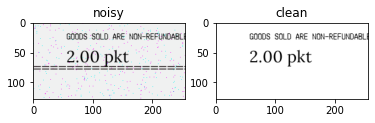

In [210]:
img, img_clean, tb = create_image()
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('noisy')
plt.subplot(1,2,2)
plt.imshow(img_clean)
plt.title('clean')
display(tb)

In [211]:
path = '/home/dk/docrv2_sroie/DB/'
name = 'denoise_test_100'
label = 'denoise'
numImage = 100
cache = {}

db_data = create_data_db(path=path, name=name, description='datadb_d2gan',data_class=label)
db_data_db = db_data.open_db(b'db_data')
ind = 0

for idx in tqdm(range(numImage)):
    img, img_clean, tb = create_image()
    cache = update_cache(cache, index=ind, label=label, ref=label, char_c=tb, image=img)
    ind = ind + 1
    cache = update_cache(cache, index=ind, label=label, ref=label, char_c=tb, image=img_clean)
    ind = ind + 1
    if idx % 5000 == 0:
        write_cache_to_db(db_data, db_data_db, cache)
        cache = {}
        
write_cache_to_db(db_data, db_data_db, cache)
cache = {}

  0%|          | 0/100 [00:00<?, ?it/s]/home/dk/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/dk/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████| 100/100 [00:04<00:00, 23.29it/s]


In [ ]:
# apply cycleGAN later here

In [212]:
refresh_main_db()

+--------------------+---------------------------------------------+
| Key                | Value                                       |
+--------------------+---------------------------------------------+
| d2gan_test_1       | /home/dk/docr2/DB/d2gan_test_1              |
| d2gan_test_100     | /home/dk/docrv2_sroie/DB/d2gan_test_100     |
| d2gan_test_1000    | /home/dk/docrv2_sroie/DB/d2gan_test_1000    |
| d2gan_train_100000 | /home/dk/docrv2_sroie/DB/d2gan_train_100000 |
| denoise_test_100   | /home/dk/docrv2_sroie/DB/denoise_test_100   |
| recog_test_1       | /home/dk/docr2/DB/recog_test_1              |
| recog_test_1000    | /home/dk/docr2/DB/recog_test_1000           |
| recog_train_100000 | /home/dk/docr2/DB/recog_train_100000        |
+--------------------+---------------------------------------------+


['d2gan_train_100000',
 'd2gan_test_1000',
 'recog_train_100000',
 'denoise_test_100',
 'recog_test_1000',
 'd2gan_test_100',
 'recog_test_1',
 'd2gan_test_1']